In [8]:
#import sys
#sys.path.append('/Users/cauaveiga/Documents/ENGENHARIA FÍSICA/3º ANO/2º Semestre/Métodos Computacionais')
#import pde as pde

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.linalg

import timeit


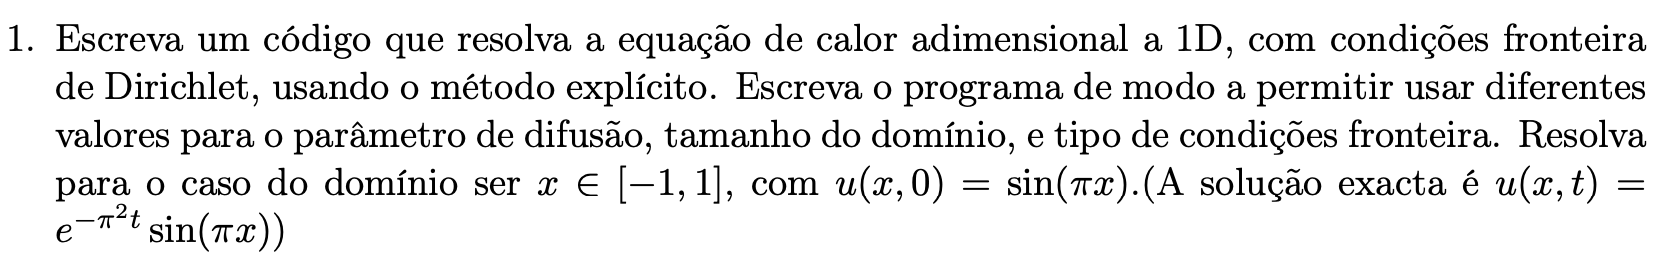

In [2]:
def Forward_Euler(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
    '''

    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    print('dx = {:.5}'.format(dx))

    
    
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    print(f'número de Fourier = {round(F,6)}')
    u    = np.zeros(Nx+1)           # incógnita u no novo nível de tempo
    u_1  = np.zeros(Nx+1)           # incógnita u no nível de tempo anterior

    # Aplicar condição inicial  u(x,0) = I(x)
    
    u_1 = cond_inicial(x,xf,a,F)
    init = u_1.copy()
        
    t = 0
    while t < Tf+dt:  
        
        # Calcular u em todos os nodos internos
        u[1:Nx] = u_1[1:Nx] + F*(u_1[0:Nx-1] - 2*u_1[1:Nx] + u_1[2:Nx+1])
            
        # Aplicar condições fronteira (aqui nem seria necessário! Porquê?)
        u[0], u[Nx] = cond_fronteira(xi,xf,t)

        # Actualizar u_1 antes de passar ao próximo passo
        u,u_1 = u_1,u
        
        t += dt
        


    #plt.plot(x,u,'b',x,init,'r--')
    #plt.plot(u,'b')
    #plt.show()
    
    return x,u,init

In [6]:
# Funções para o exemplo

def initial(*args):
    x = args[0]
    return np.sin(np.pi*x)

def front(*args):
    return 0,0

def exat(x,t=0.02):
    return np.exp(-np.pi**2 * t)*np.sin(np.pi*x)

dx = 0.03125
número de Fourier = 0.5


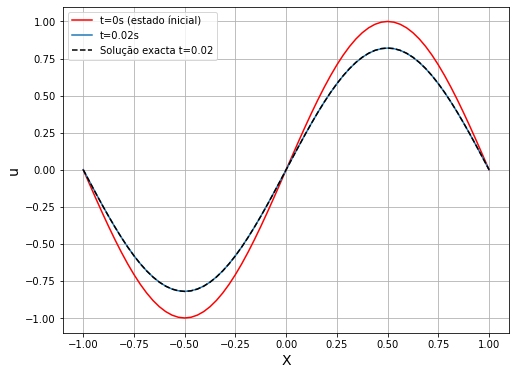

In [7]:
x,u,init = Forward_Euler(a=1, Nx=64, xi=-1, xf=1,Tf=0.02, cond_inicial=initial, cond_fronteira=front)

plt.figure(figsize=(8,6))
plt.plot(x,init,color='r',label='t=0s (estado ínicial)')
plt.plot(x,u,label='t=0.02s')
plt.plot(x,exat(x),'--',color='black',label='Solução exacta t=0.02')

plt.xlabel('X',fontsize=14)
plt.ylabel('u',fontsize=14)

plt.legend()
plt.grid()
plt.show()

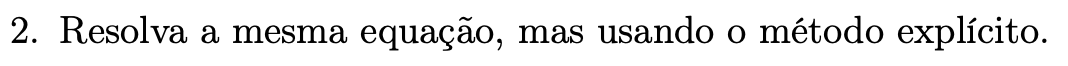

In [24]:
def Backward_Euler(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
    '''
    # Calculo parametros
    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    u   = np.zeros(Nx+1)          # incógnita u no novo nível de tempo
    u_1 = np.zeros(Nx+1)          # incógnita u no nível de tempo anterior
    
    # Representação de uma matriz esparsa e do vector do lado direito
    principal  = np.zeros(Nx+1)
    inferior = np.zeros(Nx)
    superior = np.zeros(Nx)
    b     = np.zeros(Nx+1)

    # Precálculo da matriz esparsa
    principal[:] = 1 + 2*F
    inferior[:] = -F  
    superior[:] = -F 
    
    # Inserir condições fronteira na matriz
    principal[0] = 1
    principal[Nx] = 1

    A = scipy.sparse.diags(
        diagonals=[principal, inferior, superior],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    #print (A.todense())  # Transforma na forma densa da matriz, para verificação.

    # Inserir condição inicial
    u_1 = cond_inicial(x,xf,a,F)
    init = u_1.copy()

    t = 0
    while t < Tf+dt: 
        
        b = u_1 # Vector b (da direita) = u_{t-1}
        b[0], b[-1] = cond_fronteira(xi,xf,t)  # condições fronteira
        u[:] = scipy.sparse.linalg.spsolve(A, b) # Resolvendo a AU=b
        u_1[:] = u # atualiza u_{t-1} para o próximo passo 
        
        t += dt
        
    return x,u,init

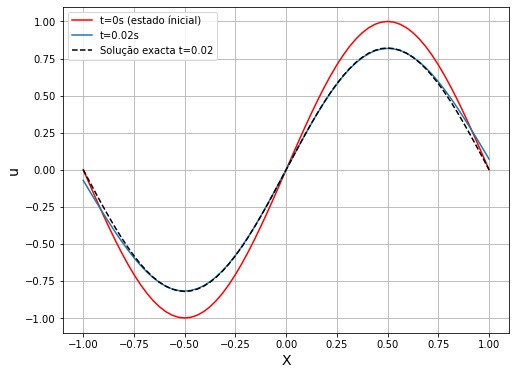

In [25]:
x,u,init = Backward_Euler(a=1, Nx=64, xi=-1, xf=1,Tf=0.02, cond_inicial=initial, cond_fronteira=front)

plt.figure(figsize=(8,6))
plt.plot(x,init,color='r',label='t=0s (estado ínicial)')
plt.plot(x,u,label='t=0.02s')
plt.plot(x,exat(x),'--',color='black',label='Solução exacta t=0.02')

plt.xlabel('X',fontsize=14)
plt.ylabel('u',fontsize=14)

plt.legend()
plt.grid()
plt.show()